# Import Package

In [52]:
import numpy as np
import pandas as pd 

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pickle

In [6]:
print(f'''
{np.__version__},
{pd.__version__},
{tf.__version__}''')


1.21.6,
1.3.5,
2.8.2


In [7]:
!python --version

Python 3.7.13


# Import Dataset

In [19]:
rating = pd.read_csv('/content/kuliner_rating.csv')
kuliner = pd.read_csv('/content/dataset_kuliner.csv')
user = pd.read_csv('/content/user.csv')

In [20]:
# melihat ukuran data
print(f'rating : {rating.shape}')
print(f'kuliner : {kuliner.shape}')
print(f'user : {user.shape}')

rating : (10000, 4)
kuliner : (40, 12)
user : (300, 3)


# Persiapan Dataset

In [21]:
rating.head()

,Unnamed: 0,User_Id,Place_Id,Place_Ratings
0,0,1,23,3
1,1,1,36,2
2,2,1,19,5
3,3,1,3,3
4,4,1,8,4


In [22]:
df = rating.copy()

In [23]:
#ENCODING
def dict_encoder(col, data=df):
  unique_val = data[col].unique().tolist()
  val_to_val_encoded = {x: i for i, x in enumerate(unique_val)}
  val_encoded_to_val = {i: x for i, x in enumerate(unique_val)}
  return val_to_val_encoded, val_encoded_to_val

In [24]:
user_to_user_encoded, user_encoded_to_user = dict_encoder('User_Id')
df['user'] = df['User_Id'].map(user_to_user_encoded)

In [25]:
# Encoding Place_Id
place_to_place_encoded, place_encoded_to_place = dict_encoder('Place_Id')

# Mapping Place_Id ke dataframe place
df['place'] = df['Place_Id'].map(place_to_place_encoded)

In [26]:
# Mendapatkan jumlah user dan hotel
num_users, num_place = len(user_to_user_encoded), len(place_to_place_encoded)
# mengubah nilai rating menjadi nilai float
df['Place_Ratings'] = df['Place_Ratings'].values.astype(np.float32)
# Mendapatkan nilai minimum dan maksimum rating
min_rating, max_rating = min(df['Place_Ratings']), max(df['Place_Ratings'])

In [27]:
print(f'Jumlah user : {num_users}')
print(f'Jumlah kuliner : {num_place}')
print(f'Rating minimum : {min_rating}')
print(f'Rating maximum : {max_rating}')

Jumlah user : 300
Jumlah kuliner : 39
Rating minimum : 1.0
Rating maximum : 5.0


In [28]:
# Mengacak dataset
df = df.sample(frac=1, random_state=42)
df.head()

,Unnamed: 0,User_Id,Place_Id,Place_Ratings,user,place
6252,6252,188,9,3.0,187,28
4684,4684,142,16,2.0,141,8
1731,1731,54,17,3.0,53,9
4742,4742,144,20,3.0,143,27
4521,4521,138,15,5.0,137,16


# Splitting Dataset

In [29]:
# Mambuat Variable x
x = df[['user', 'place']].values
# membuat Variable y
y = df['Place_Ratings'].apply(lambda x: (x-min_rating)/(max_rating-min_rating)).values

# split dataset
indices = int(0.8*df.shape[0])
x_train, x_test, y_train, y_test = (x[:indices],
                                    x[indices:],
                                    y[:indices],
                                    y[indices:]
                                    )
print(f'x_train : {x_train.shape}')
print(f'x_test : {x_test.shape}')
print(f'y_train : {y_train.shape}')
print(f'y_test : {y_test.shape}')

x_train : (8000, 2)
x_test : (2000, 2)
y_train : (8000,)
y_test : (2000,)


In [30]:
class Recommended(keras.Model):
  def __init__(self,num_users, num_places, embedding_size, **kwargs):
    super(Recommended, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_places = num_places
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(num_users,
                                           embedding_size,
                                           embeddings_initializer = 'he_normal',
                                           embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users,1)
    self.places_embedding = layers.Embedding(num_places,
                                             embedding_size,
                                             embeddings_initializer='he_normal',
                                             embeddings_regularizer= keras.regularizers.l2(1e-6)
                                             )
    self.places_bias = layers.Embedding(num_places,1)

  def call(self, inputs):
    user_vec = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:,0])
    places_vec = self.places_embedding(inputs[:,1])
    places_bias = self.places_bias(inputs[:,1])

    dot_user_places = tf.tensordot(user_vec, places_vec, 2)

    x = dot_user_places + user_bias + places_bias

    return tf.nn.sigmoid(x)


In [31]:
model = Recommended(num_users, num_place, 50)

model.compile(loss = keras.losses.BinaryCrossentropy(),
              optimizer= keras.optimizers.Adam(learning_rate=0.0004),
              metrics=[keras.metrics.RootMeanSquaredError()]
              )

# training Model

In [32]:
history = model.fit(
    x = x_train,
    y = y_train,
    epochs = 100,
    validation_data = (x_test, y_test)
)

Epoch 1/100
250/250 [==============================] - 2s 4ms/step - loss: 0.7624 - root_mean_squared_error: 0.3849 - val_loss: 0.7532 - val_root_mean_squared_error: 0.3813
Epoch 2/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7481 - root_mean_squared_error: 0.3781 - val_loss: 0.7505 - val_root_mean_squared_error: 0.3803
Epoch 3/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7479 - root_mean_squared_error: 0.3775 - val_loss: 0.7464 - val_root_mean_squared_error: 0.3782
Epoch 4/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7368 - root_mean_squared_error: 0.3718 - val_loss: 0.7439 - val_root_mean_squared_error: 0.3767
Epoch 5/100
250/250 [==============================] - 1s 3ms/step - loss: 0.7448 - root_mean_squared_error: 0.3767 - val_loss: 0.7419 - val_root_mean_squared_error: 0.3753
Epoch 6/100
250/250 [==============================] - 1s 6ms/step - loss: 0.7376 - root_mean_squared_error: 0.3726 - val_loss: 0.7428 

# Evaluasi Model

In [33]:
model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.7042 - root_mean_squared_error: 0.3523


[0.7042046189308167, 0.35233914852142334]

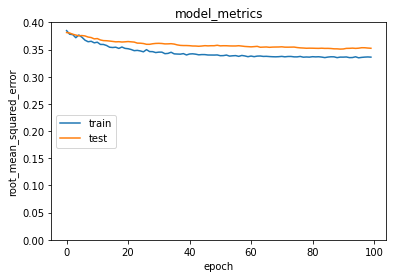

In [34]:
import matplotlib.pyplot as plt

plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.ylim(ymin=0, ymax=0.4)
plt.legend(['train', 'test'], loc='center left')
plt.show()

# Penerapan Model

In [35]:
kuliner.columns

Index(['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City',
       'Rating', 'Coordinate', 'Lat', 'Long', 'Price', 'Images'],
      dtype='object')

In [37]:
place_df = kuliner[['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City',
       'Rating', 'Coordinate', 'Lat', 'Long', 'Price', 'Images']]
place_df.columns = ['Place_Id', 'Kuliner_Name', 'Description', 'Category', 'alamat', 'City',
       'Rating', 'Coordinate', 'Lat', 'Long', 'Price', 'Images']
df = rating.copy()

In [38]:
# Mengambil sample user
user_id = df.User_Id.sample(1).iloc[0]
place_visited_by_user = df[df.User_Id == user_id]

In [39]:
# Membuat data lokasi yang belum dikunjungi user
place_not_visited = place_df[~place_df['Place_Id'].isin(place_visited_by_user.Place_Id.values)]['Place_Id'] 
place_not_visited = list(
    set(place_not_visited).intersection(set(place_to_place_encoded.keys()))
)
 
place_not_visited = [[place_to_place_encoded.get(x)] for x in place_not_visited]
user_encoder = user_to_user_encoded.get(user_id)
user_place_array = np.hstack(
    ([[user_encoder]] * len(place_not_visited), place_not_visited)
)

In [41]:
# Mengambil top 5 recommendation
ratings = model.predict(user_place_array).flatten()
top_ratings_indices = ratings.argsort()[-5:][::-1]
recommended_place_ids = [
    place_encoded_to_place.get(place_not_visited[x][0]) for x in top_ratings_indices
]
 

print('')
print('----' * 15)
print('Top 5 place recommendation')
print('----' * 15)
 
recommended_place = place_df[place_df['Place_Id'].isin(recommended_place_ids)]
for row, i in zip(recommended_place.itertuples(), range(1,8)):
    print(i,'.', row.Kuliner_Name, '\n    ', row.alamat, ',', 'titik koordinat ', row.Coordinate, ',', 'Rating Wisata ', row.Rating,'\n')

print('==='*15)


------------------------------------------------------------
Top 5 place recommendation
------------------------------------------------------------
1 . Sugih Roso Kuliner Jogja 
     Kadipaten, Kecamatan Kraton, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55132 , titik koordinat  {'lat': -7.80599216022402, 'lng': 110.358418118914} , Rating Wisata  5.0 

2 . Gudeg Permata Bu Narti 
     Jl. Gajah Mada No.2, Gunungketur, Pakualaman, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55111 , titik koordinat  {'lat': -7.80121992173576, 'lng': 110.373197048811} , Rating Wisata  4.5 

3 . Gudeg Yu Djum 
     Jl. Wijilan No.167, Panembahan, Kecamatan Kraton, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55131 , titik koordinat  {'lat': -7.80492911258682, 'lng': 110.366757428255} , Rating Wisata  4.3 

4 . Kebelet Belut - Jogjakarta 
     Jl. Ipda Tut Harsono No.42, Muja Muju, Kec. Umbulharjo, Kota Yogyakarta, Daerah Istimewa Yogyakarta 55165 , titik koordinat  {'lat': -7.7966752392197, 'lng': 110.39

# Save Model

In [42]:
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model.
# with open('model.tflite', 'wb') as f:
#   f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpiqpaze92/assets


In [56]:
filename = 'kuliner_jogyakarta_model.pkl'
pickle.dump(model, open(filename, 'wb'))

INFO:tensorflow:Assets written to: ram://7a5f6002-395b-4df0-84d3-2276807e66aa/assets


INFO:tensorflow:Assets written to: ram://7a5f6002-395b-4df0-84d3-2276807e66aa/assets


In [57]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.evaluate(x=x_test, y=y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.7042 - root_mean_squared_error: 0.3523
